In [1]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [1]:
import pyro
from pyro.optim import Adam, ClippedAdam
from pyro.infer import TraceMeanField_ELBO, TraceEnum_ELBO, TraceGraph_ELBO, Trace_ELBO

import pandas as pd
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from typing import Dict, Tuple, Optional
import re

import matplotlib.pyplot as plt
import numpy as np


In [2]:
base = "/Users/lucreziavaleriani/Desktop/orfeo_scratch/utils_locate/simulations_rRACES/test_dr/out/clonal/sim_21/cov_70_p_0.9"
data = pd.read_csv(base + "/mirr_smooth_snv.csv", sep = ',', on_bad_lines='skip') 

In [3]:
data['pos'] = range(1, len(data) + 1)
data['baf'] = data['median_baf'].apply(lambda x: 1 - x if x > 0.5 else x)
data = data[data['baf']>0]
data_input = {'baf':torch.tensor(np.array(data.baf).reshape(-1, 1)),
            'dr':torch.tensor(np.array(data.median_dr).reshape(-1, 1)),
            'dp_snp':torch.tensor(np.array(data.mean_dp).reshape(-1, 1)),
            'orginal_baf':torch.tensor(np.array(data.median_baf).reshape(-1, 1)),
            'vaf':torch.tensor(np.array(data.vaf).reshape(-1, 1)),
            'dp_snv':torch.tensor(np.array(data.DP).reshape(-1, 1))}

In [4]:
from locate.utils import estimate_ploidy
ploidy, seg_table = estimate_ploidy(data, return_details=True)
print(f"Ploidy ≈ {ploidy:.3f}")

Ploidy ≈ 2.425


In [5]:
# T = data.baf.shape[0]
# prior_bp = torch.zeros(T)
# prior_bp[[1115, 4464, 4673]] = 1.0       

In [6]:
import locate.locate as l
from locate.models import Clonal
from locate.utils import plot_loss

In [7]:
fix_ploidy = False
print(ploidy)

2.424880202902391


In [8]:
locate = l.LOCATE(CUDA = False)

locate.set_model(Clonal)
locate.set_optimizer(ClippedAdam)
locate.set_loss(TraceEnum_ELBO)
locate.initialize_model({"baf":data_input["baf"],
                         "dr":data_input["dr"], 
                         "dp_snp":data_input["dp_snp"], 
                         "vaf": data_input["vaf"], 
                         "dp": data_input["dp_snv"]})

locate.set_model_params({"jumping_prob" : 1e-6,
                         "fix_purity": False,
                         "fix_ploidy" : fix_ploidy, 
                         "prior_purity": 0.9,
                         "prior_ploidy": float(ploidy),
                         "scaling_factors": [1,1,1],
                         'hidden_dim': 4,
                         "prior_bp": None,
                        "lambda_cn": 1.0,          # ΔCN penalty slope used to shape the prior
                        "alpha_conc": 50.0,        # global Dirichlet concentration (higher = stronger prior)
                        "alpha_self_boost": 3.0,   # extra mass on the diagonal
                        "alpha_dip_boost": 0.5,    # extra mass on diploid column (if present)
                        "bp_strength": 3.0,
                        "sample_type":"clinical"})


/Users/lucreziavaleriani/opt/anaconda3/envs/locate/lib/python3.11/site-packages/torch/__init__.py:696: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/tensor/python_tensor.cpp:453.)
  _C._set_default_tensor_type(t)


In [9]:
ll = locate.run(steps = 100, param_optimizer = {"lr" : 0.05}, guide_kind="normal")

ELBO: -4932.523425253  : 100%|██████████| 100/100 [00:02<00:00, 44.95it/s]


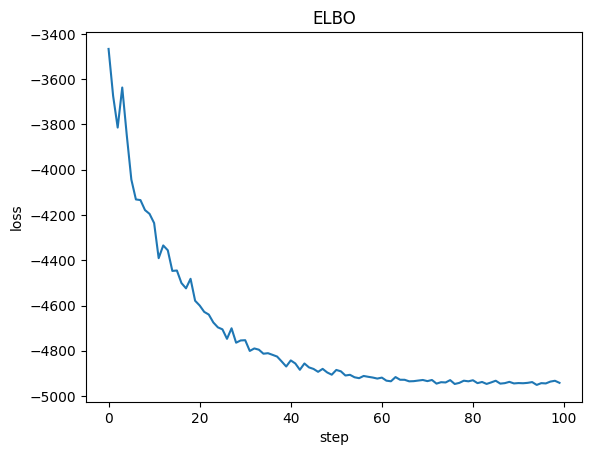

In [10]:
plot_loss(ll[0])

In [11]:
params = locate.learned_parameters_Clonal()

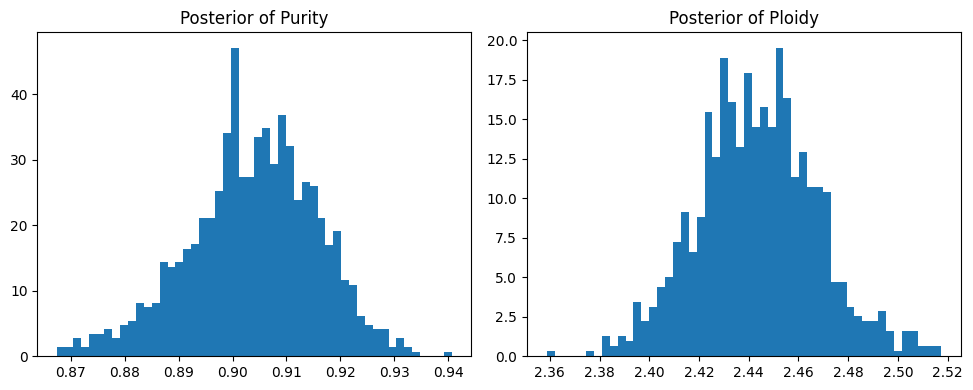

In [12]:
from locate.utils import plot_purity_ploidy_hist
draws = locate.posterior_draws(num_samples=1000, sites=["purity","ploidy"])
plot_purity_ploidy_hist(draws)


In [13]:
purity = params['purity']
if not fix_ploidy:
    ploidy = params['ploidy']
else:
    ploidy = None
print(purity, ploidy)

[0.9074635] [2.4364836]


In [14]:
res_plot = pd.DataFrame({'CN_Major':params["CN_Major"]+0.05,
                    'CN_minor':params["CN_minor"]-0.05,
                    'pos':[i for i in range(len(params["CN_minor"]))]})

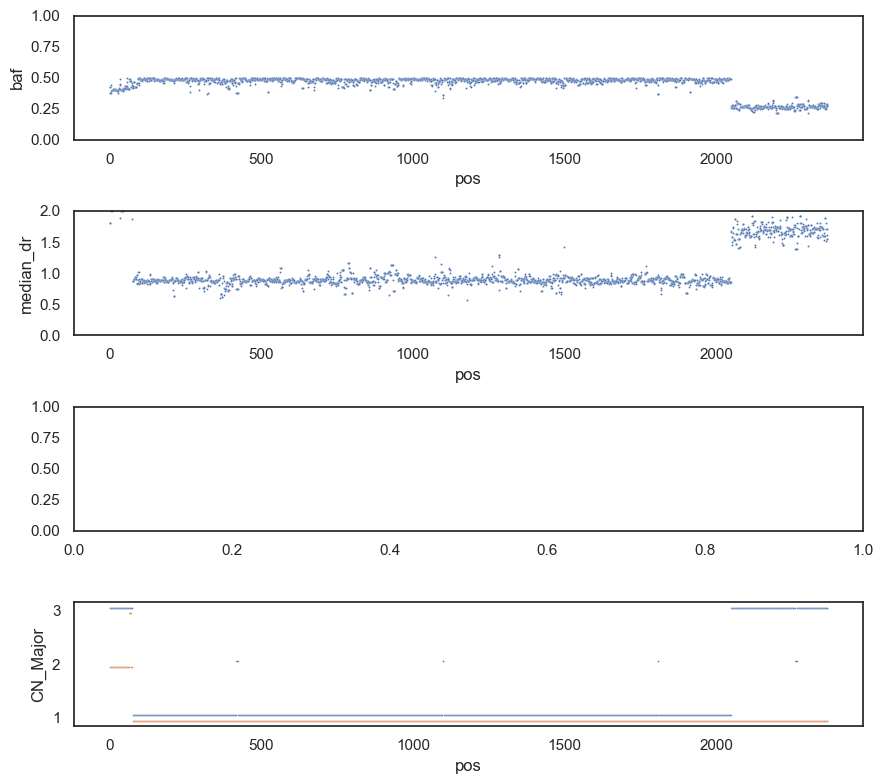

In [15]:
sns.set_theme(style="white", font_scale=1)
fig, axes = plt.subplots(4, 1, figsize=(9, 8))

baf = sns.scatterplot(data=data, x="pos", y="baf", s=2, ax=axes[0])
dr = sns.scatterplot(data=data, x="pos", y="median_dr", s=2, ax=axes[1])

cn = sns.scatterplot(data=res_plot, x="pos", y="CN_Major", s=1, ax=axes[3], legend=False)
cn = sns.scatterplot(data=res_plot, x="pos", y="CN_minor", s=1, ax=axes[3], legend=False)

axes[0].set_ylim(0,1) 
axes[1].set_ylim(0,2) 
axes[2].set_ylim(0,1) 

fig.tight_layout()

In [16]:
res = pd.DataFrame({'CN_Major':params["CN_Major"],
                    'CN_minor':params["CN_minor"],
                    'pos':[i for i in range(len(params["CN_minor"]))]})

In [33]:
import sys, os
sys.path.append(os.path.abspath(".."))

from scripts.ProCESS.infer_ProCESS import score_cn_predictions
out_df = score_cn_predictions(data, res, sample_name="sim_1")
out_df['summary']

,sample,n_positions,allelic_accuracy,total_cn_accuracy,total_cn_mae,precision_totalCN_macro,recall_totalCN_macro,f1_totalCN_macro,precision_pair_macro,recall_pair_macro,f1_pair_macro
0,sim_1,2366,0.989856,0.989856,0.011412,0.998768,0.962029,0.979642,0.998768,0.962029,0.979642


In [ ]:
import numpy as np
import pandas as pd

def segment_allele_specific_cn(df, pos_col="pos",
                               major_col="CN_Major", minor_col="CN_minor"):
    df = df.sort_values(pos_col).reset_index(drop=True)
    change = ((df[major_col] != df[major_col].shift()) |
              (df[minor_col] != df[minor_col].shift()))
    seg_id = change.cumsum()
    segs = (df.groupby(seg_id)
              .agg(seg_start=(pos_col, "min"),
                   seg_end=(pos_col, "max"),
                   CN_major=(major_col, "first"),
                   CN_minor=(minor_col, "first"),
                   n_bins=(pos_col, "size"))
              .reset_index(drop=True))
    segs["length"] = segs["seg_end"] - segs["seg_start"] + 1
    segs["seg_id"] = np.arange(len(segs))
    return segs[["seg_id","seg_start","seg_end","length","n_bins","CN_major","CN_minor"]]

def _l1_dist(a_major, a_minor, b_major, b_minor):
    return abs(a_major - b_major) + abs(a_minor - b_minor)

def coalesce_same_cn(segs):
    """
    Merge consecutive segments that share the same (CN_major, CN_minor).
    Treat segments as mergeable if they are touching or overlapping.
    """
    if len(segs) <= 1:
        return segs.copy()

    s = segs.sort_values("seg_start").reset_index(drop=True).copy()
    out = []
    cur = s.iloc[0].to_dict()

    for i in range(1, len(s)):
        row = s.iloc[i]
        same_state = (row["CN_major"] == cur["CN_major"]) and (row["CN_minor"] == cur["CN_minor"])
        touching = row["seg_start"] <= cur["seg_end"] + 1  # contiguous or overlap
        if same_state and touching:
            # extend current
            cur["seg_end"] = max(cur["seg_end"], int(row["seg_end"]))
            cur["length"]  = cur["seg_end"] - cur["seg_start"] + 1
            cur["n_bins"]  = int(cur["n_bins"]) + int(row["n_bins"])
        else:
            out.append(cur)
            cur = row.to_dict()
    out.append(cur)

    out = pd.DataFrame(out).reset_index(drop=True)
    out["seg_id"] = np.arange(len(out))
    return out[["seg_id","seg_start","seg_end","length","n_bins","CN_major","CN_minor"]]

def merge_micro_segments(segs, min_bins=5, max_passes=100):
    """
    Merge segments shorter than min_bins into neighbors; after each pass,
    coalesce any newly adjacent equal-CN segments.
    """
    s = segs.sort_values("seg_start").reset_index(drop=True).copy()

    def _merge_once(s):
        if len(s) <= 1:
            return s, False
        short_idx = s.index[s["n_bins"] < min_bins].tolist()
        if not short_idx:
            return s, False

        to_drop = []
        for i in short_idx:
            if i in to_drop or i >= len(s):
                continue
            left = i - 1 if i - 1 >= 0 else None
            right = i + 1 if i + 1 < len(s) else None
            if left is None and right is None:
                continue

            target = None
            # Prefer identical state neighbor
            if left is not None and \
               (s.loc[left, "CN_major"] == s.loc[i, "CN_major"]) and \
               (s.loc[left, "CN_minor"] == s.loc[i, "CN_minor"]):
                target = left
            if right is not None and \
               (s.loc[right, "CN_major"] == s.loc[i, "CN_major"]) and \
               (s.loc[right, "CN_minor"] == s.loc[i, "CN_minor"]):
                if target is None or s.loc[right, "length"] > s.loc[target, "length"]:
                    target = right

            # Else closest L1 distance, tie -> larger length, tie -> left
            if target is None:
                candidates = []
                if left is not None:
                    dL = _l1_dist(s.loc[i,"CN_major"], s.loc[i,"CN_minor"],
                                  s.loc[left,"CN_major"], s.loc[left,"CN_minor"])
                    candidates.append(("L", left, dL, s.loc[left,"length"]))
                if right is not None:
                    dR = _l1_dist(s.loc[i,"CN_major"], s.loc[i,"CN_minor"],
                                  s.loc[right,"CN_major"], s.loc[right,"CN_minor"])
                    candidates.append(("R", right, dR, s.loc[right,"length"]))
                candidates.sort(key=lambda x: (x[2], -x[3], x[0]))
                target = candidates[0][1]

            # Merge i into target
            new_start = min(s.loc[i, "seg_start"], s.loc[target, "seg_start"])
            new_end   = max(s.loc[i, "seg_end"],   s.loc[target, "seg_end"])
            s.loc[target, "seg_start"] = new_start
            s.loc[target, "seg_end"]   = new_end
            s.loc[target, "length"]    = new_end - new_start + 1
            s.loc[target, "n_bins"]    = s.loc[target, "n_bins"] + s.loc[i, "n_bins"]
            to_drop.append(i)

        if not to_drop:
            return s, False

        s = s.drop(index=to_drop).sort_values("seg_start").reset_index(drop=True)
        # Coalesce equal-CN neighbors formed by this pass
        s = coalesce_same_cn(s)
        return s, True

    changed = True
    passes = 0
    while changed and passes < max_passes:
        s, changed = _merge_once(s)
        passes += 1

    # Final coalesce in case last pass only touched boundaries
    s = coalesce_same_cn(s)
    return s



In [35]:
segments = segment_allele_specific_cn(res)
print(segments)
segs_merged = merge_micro_segments(segments, min_bins=10)
print(segs_merged)

    seg_id  seg_start  seg_end  length  n_bins  CN_major  CN_minor
0        0          0       64      65      65         3         2
1        1         65       70       6       6         3         3
2        2         71       75       5       5         3         2
3        3         76      417     342     342         1         1
4        4        418      422       5       5         2         1
5        5        423     1097     675     675         1         1
6        6       1098     1100       3       3         2         1
7        7       1101     1805     705     705         1         1
8        8       1806     1808       3       3         2         1
9        9       1809     2047     239     239         1         1
10      10       2048     2259     212     212         3         1
11      11       2260     2264       5       5         2         1
12      12       2265     2366     102     102         3         1
   seg_id  seg_start  seg_end  length  n_bins  CN_major  CN_mi